# RIDGE REGRESSION
A notebook to introduce ridge regression

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import copy
import pandas as pd
import numpy as np
import os
PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

In [3]:
# Where to save the figures
NOTE_ROOT_DIR = os.path.abspath('')
CHAPTER_ID = "01_ridge_regression"
IMAGES_PATH = os.path.join(NOTE_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1 - Load the Data

In [5]:
# Load x28.txt
with open(os.path.join(NOTE_ROOT_DIR, "data", "x28.txt")) as f:
    data = []
    content = f.readlines()[72:]
    for line in content:
        line  = line.strip()
        row = [float(i) for i in (line.split())[1:]]
        data.append(row)
    data = np.array(data)
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,36.0,27.0,71.0,8.1,3.34,11.4,81.5,3243.0,8.8,42.6,11.7,21.0,15.0,59.0,59.0,921.870
1,35.0,23.0,72.0,11.1,3.14,11.0,78.8,4281.0,3.6,50.7,14.4,8.0,10.0,39.0,57.0,997.875
2,44.0,29.0,74.0,10.4,3.21,9.8,81.6,4260.0,0.8,39.4,12.4,6.0,6.0,33.0,54.0,962.354
3,47.0,45.0,79.0,6.5,3.41,11.1,77.5,3125.0,27.1,50.2,20.6,18.0,8.0,24.0,56.0,982.291
4,43.0,35.0,77.0,7.6,3.44,9.6,84.6,6441.0,24.4,43.7,14.3,43.0,38.0,206.0,55.0,1071.289


In [6]:
# Inspect the field of the columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       60 non-null     float64
 1   1       60 non-null     float64
 2   2       60 non-null     float64
 3   3       60 non-null     float64
 4   4       60 non-null     float64
 5   5       60 non-null     float64
 6   6       60 non-null     float64
 7   7       60 non-null     float64
 8   8       60 non-null     float64
 9   9       60 non-null     float64
 10  10      60 non-null     float64
 11  11      60 non-null     float64
 12  12      60 non-null     float64
 13  13      60 non-null     float64
 14  14      60 non-null     float64
 15  15      60 non-null     float64
dtypes: float64(16)
memory usage: 7.6 KB


## 2 - Data Cleaning

### 2.1 - Data Missing

Saving figure missing_distri


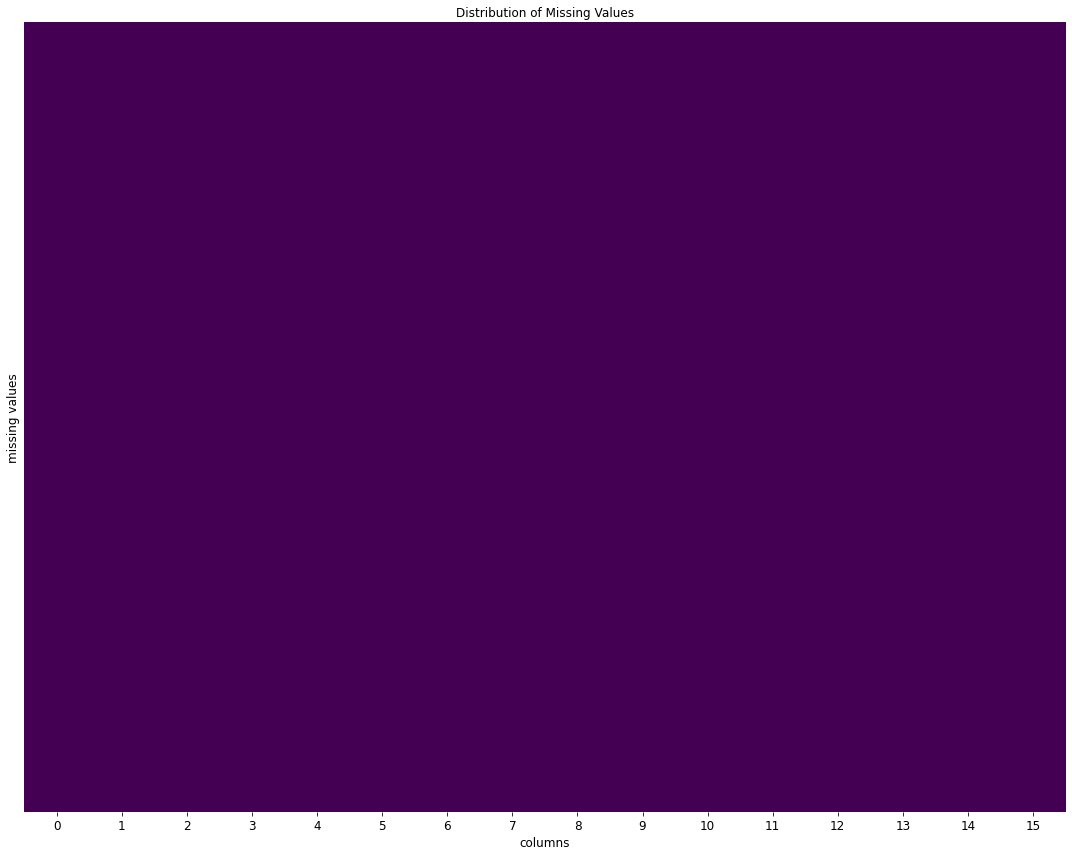

In [7]:
# Check data missing distribution
plt.figure(figsize=(15, 12))
msno = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap ='viridis')
msno.set_xlabel('columns', size=12)
msno.set_ylabel('missing values', size=12)
msno.set_title('Distribution of Missing Values', size=12)
plt.tight_layout()
save_fig("missing_distri")

In [8]:
# Calculate percentage of null values in each column
(df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
dtype: float64

### 2.2 - Noisy Data

Saving figure box_plot_features


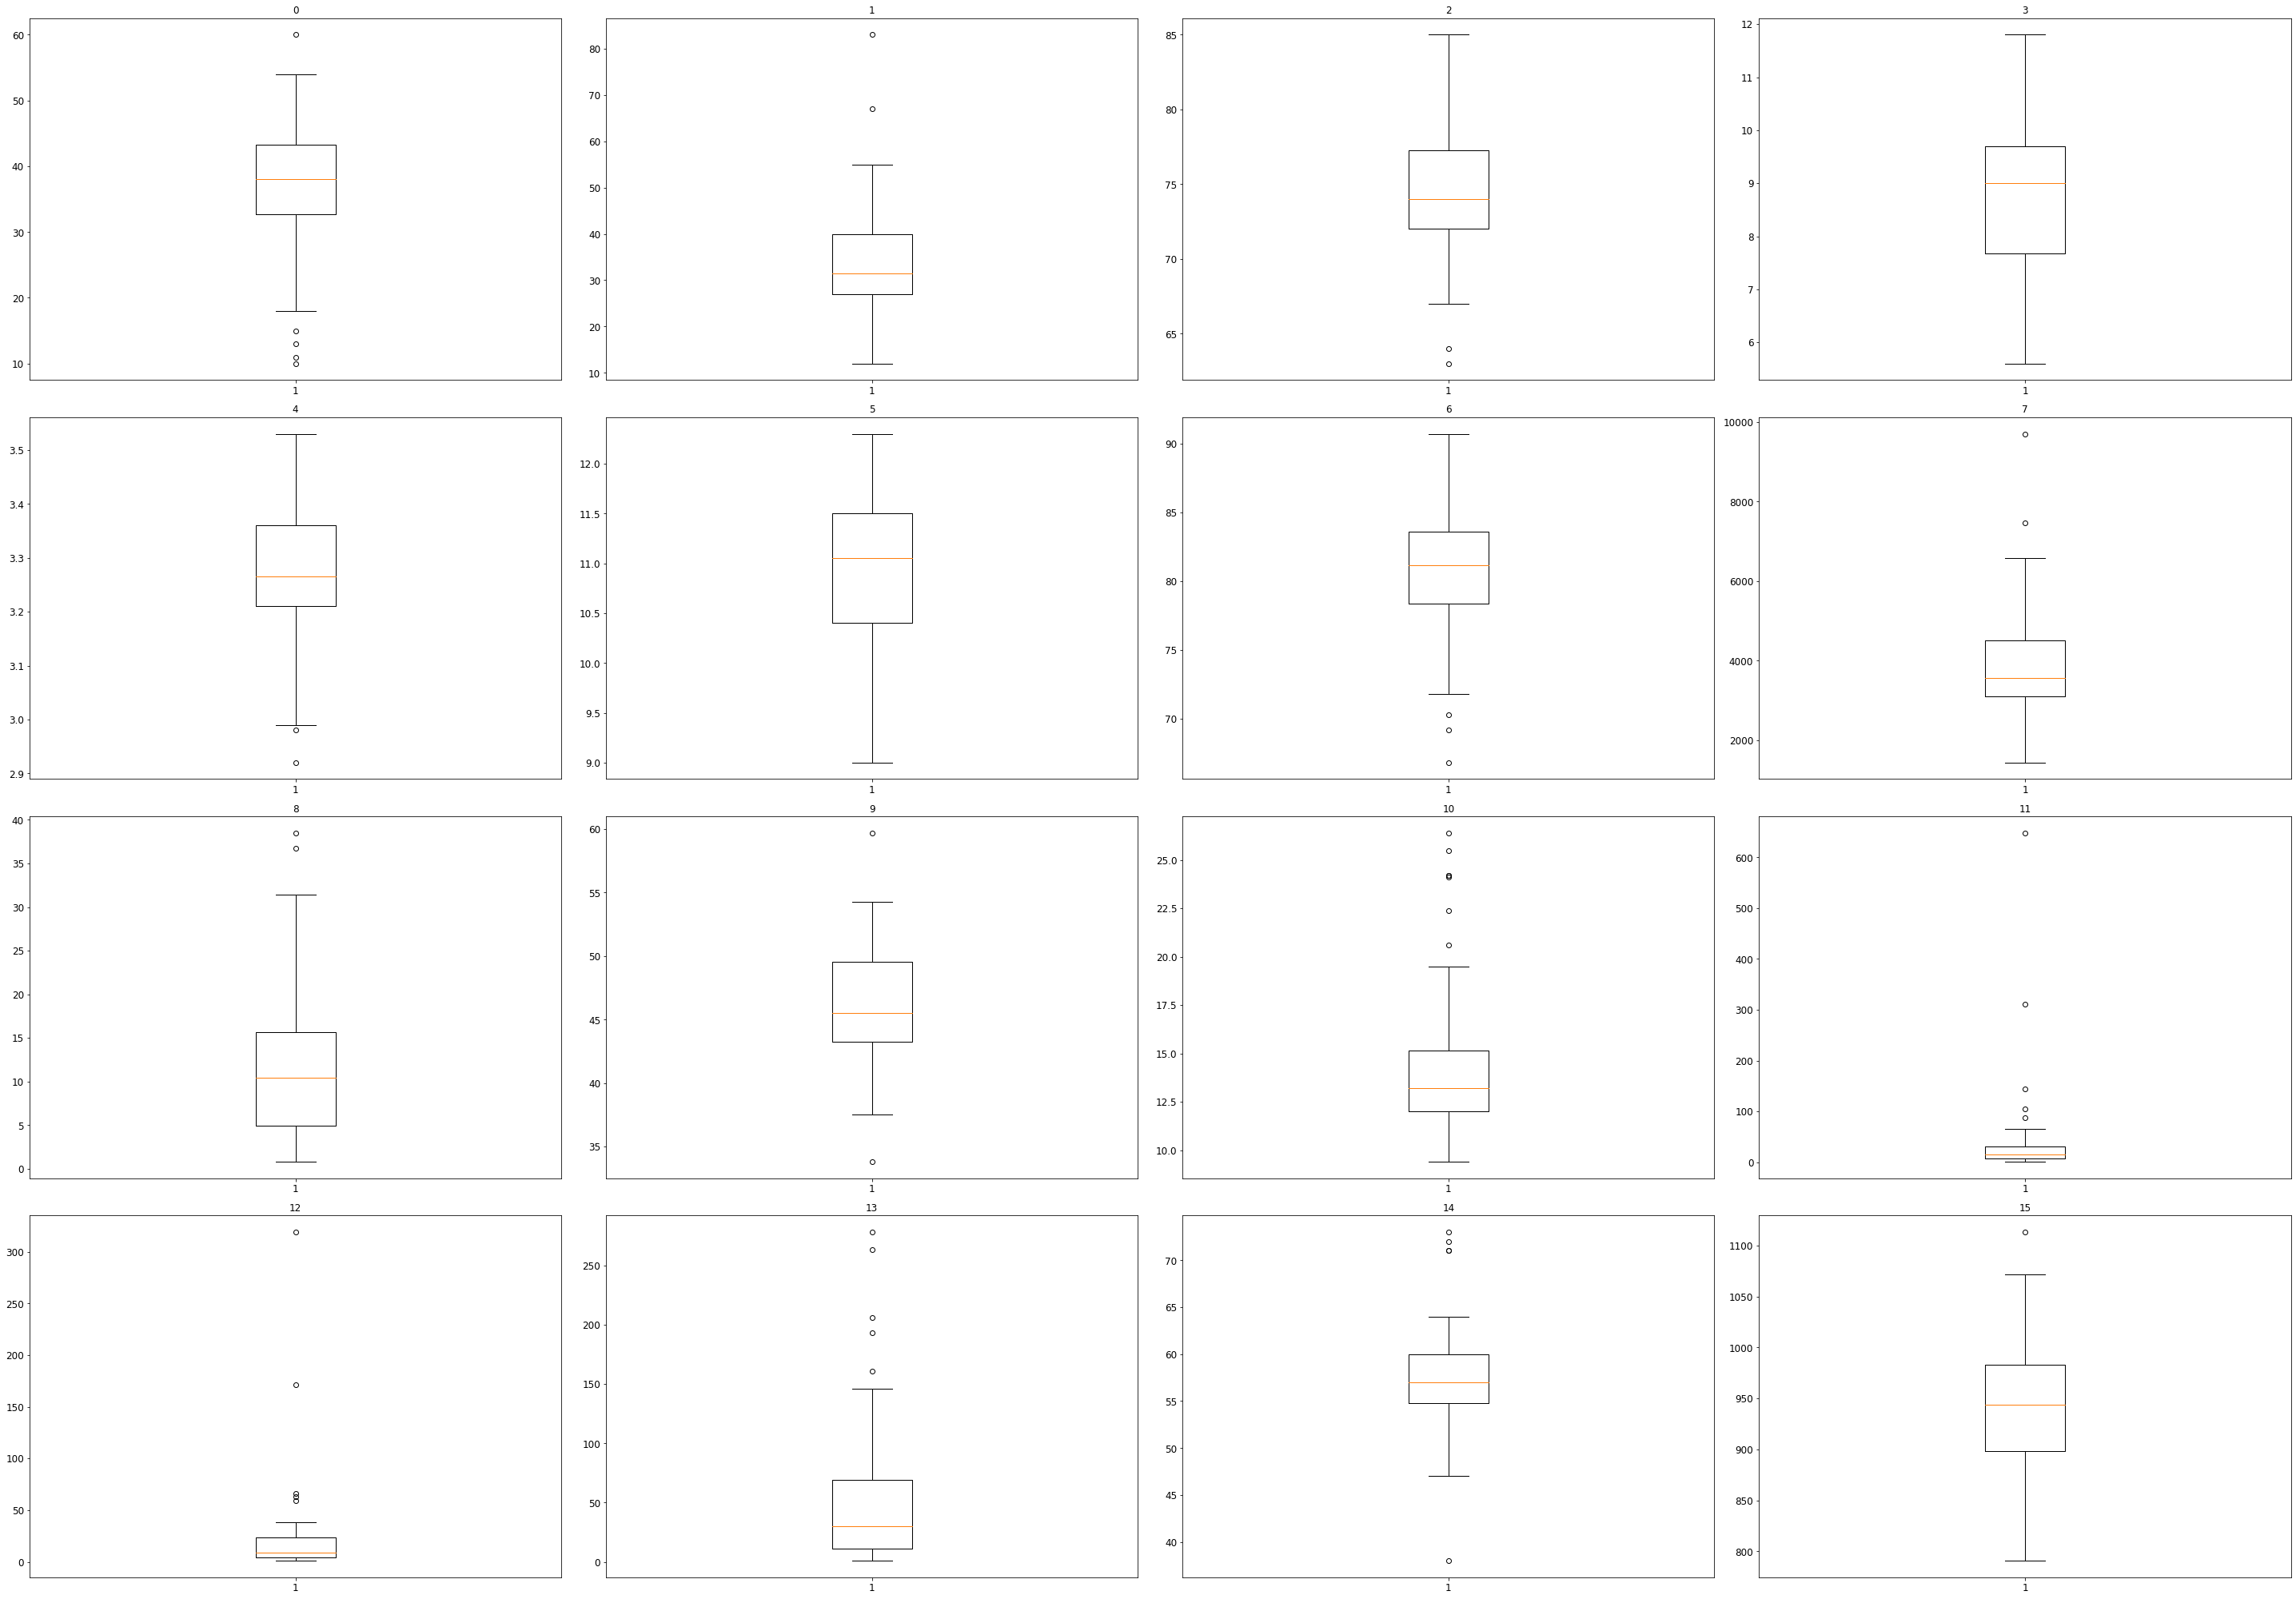

In [10]:
# Visualize the outliers using box plot
plt.figure(figsize=(40, 90))
i = 1
for column in df.columns:
    plt.subplot(13, 4, i)
    plt.boxplot(df[column], whis=1.5)
    plt.title(column)
    i += 1
plt.tight_layout()
save_fig("box_plot_features")

In [11]:
# Calculate number of univariate outliners and its percentage based on IQR mathematical formula
whis = 1.5
outlier_df = pd.DataFrame(columns=["number", "percentage", "upper_quantile", "lower_quantile"], 
                          index=df.columns)

for column in df.columns:
    q75, q25 = np.percentile(df[column], [75, 25])
    IQR = q75 - q25
    upper = q75 + (IQR * whis)
    lower = q25 - (IQR * whis)
    outlier_df.loc[column, "upper_quantile"] = upper
    outlier_df.loc[column, "lower_quantile"] = lower
    outlier_df.loc[column, "number"] = len(np.where((df[column] > upper) | (df[column] < lower))[0])
    outlier_df.loc[column, "percentage"] = len(np.where((df[column] > upper) | (df[column] < lower))[0]) * 100 / len(df)
    
outlier_df.sort_values(by=["number", "percentage"], ascending=False)

,number,percentage,upper_quantile,lower_quantile
10,7,11.666667,19.875,7.275
0,5,8.333333,59.0,17.0
11,5,8.333333,65.125,-27.875
12,5,8.333333,53.375,-25.625
13,5,8.333333,156.0,-76.0
14,5,8.333333,67.875,46.875
6,3,5.0,91.4375,70.5375
1,2,3.333333,59.5,7.5
2,2,3.333333,85.125,64.125
4,2,3.333333,3.585,2.985


## 3 - Exploratory Data Analysis

Saving figure histogram_plots


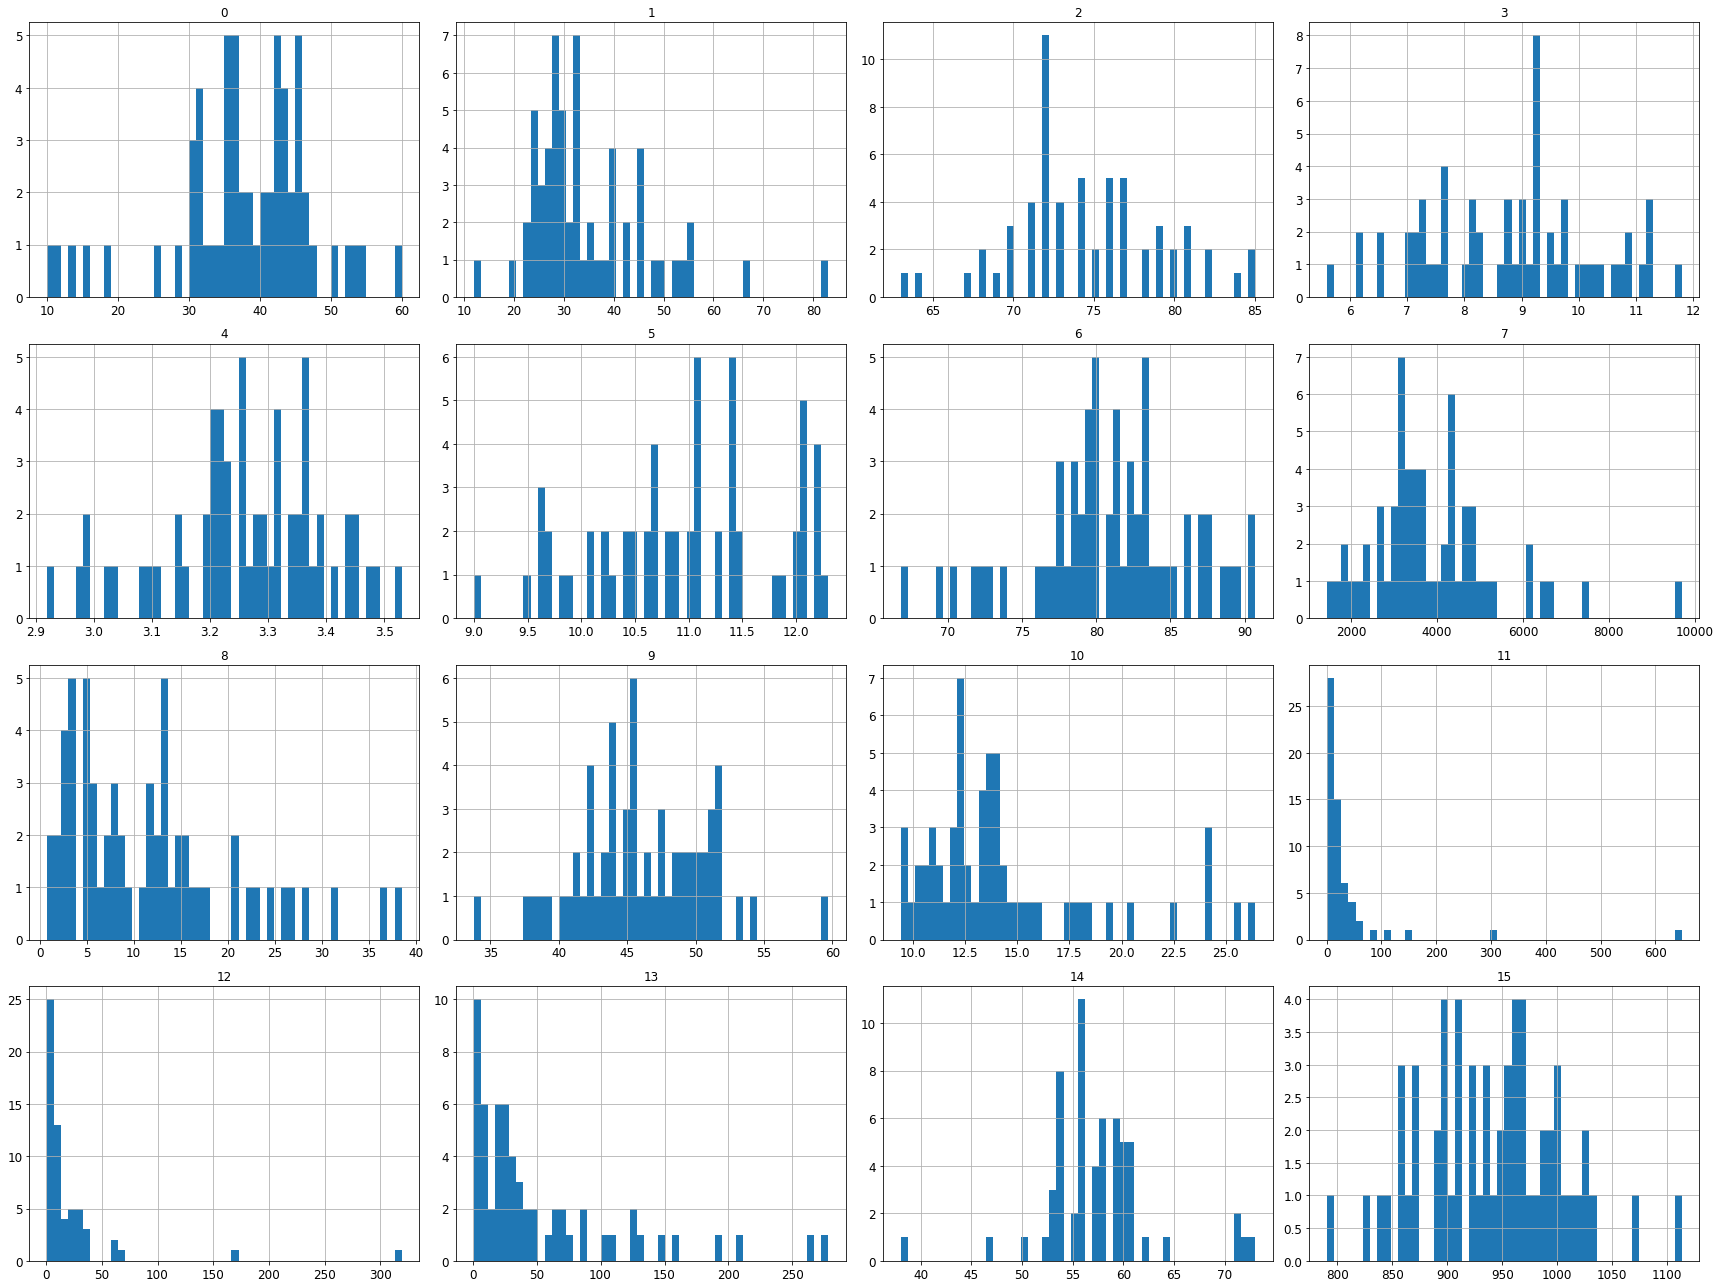

In [12]:
# Histogram of numerical variables
df.hist(bins=50, figsize=(24, 18))
plt.tight_layout()
save_fig("histogram_plots")

Saving figure performance_correlation


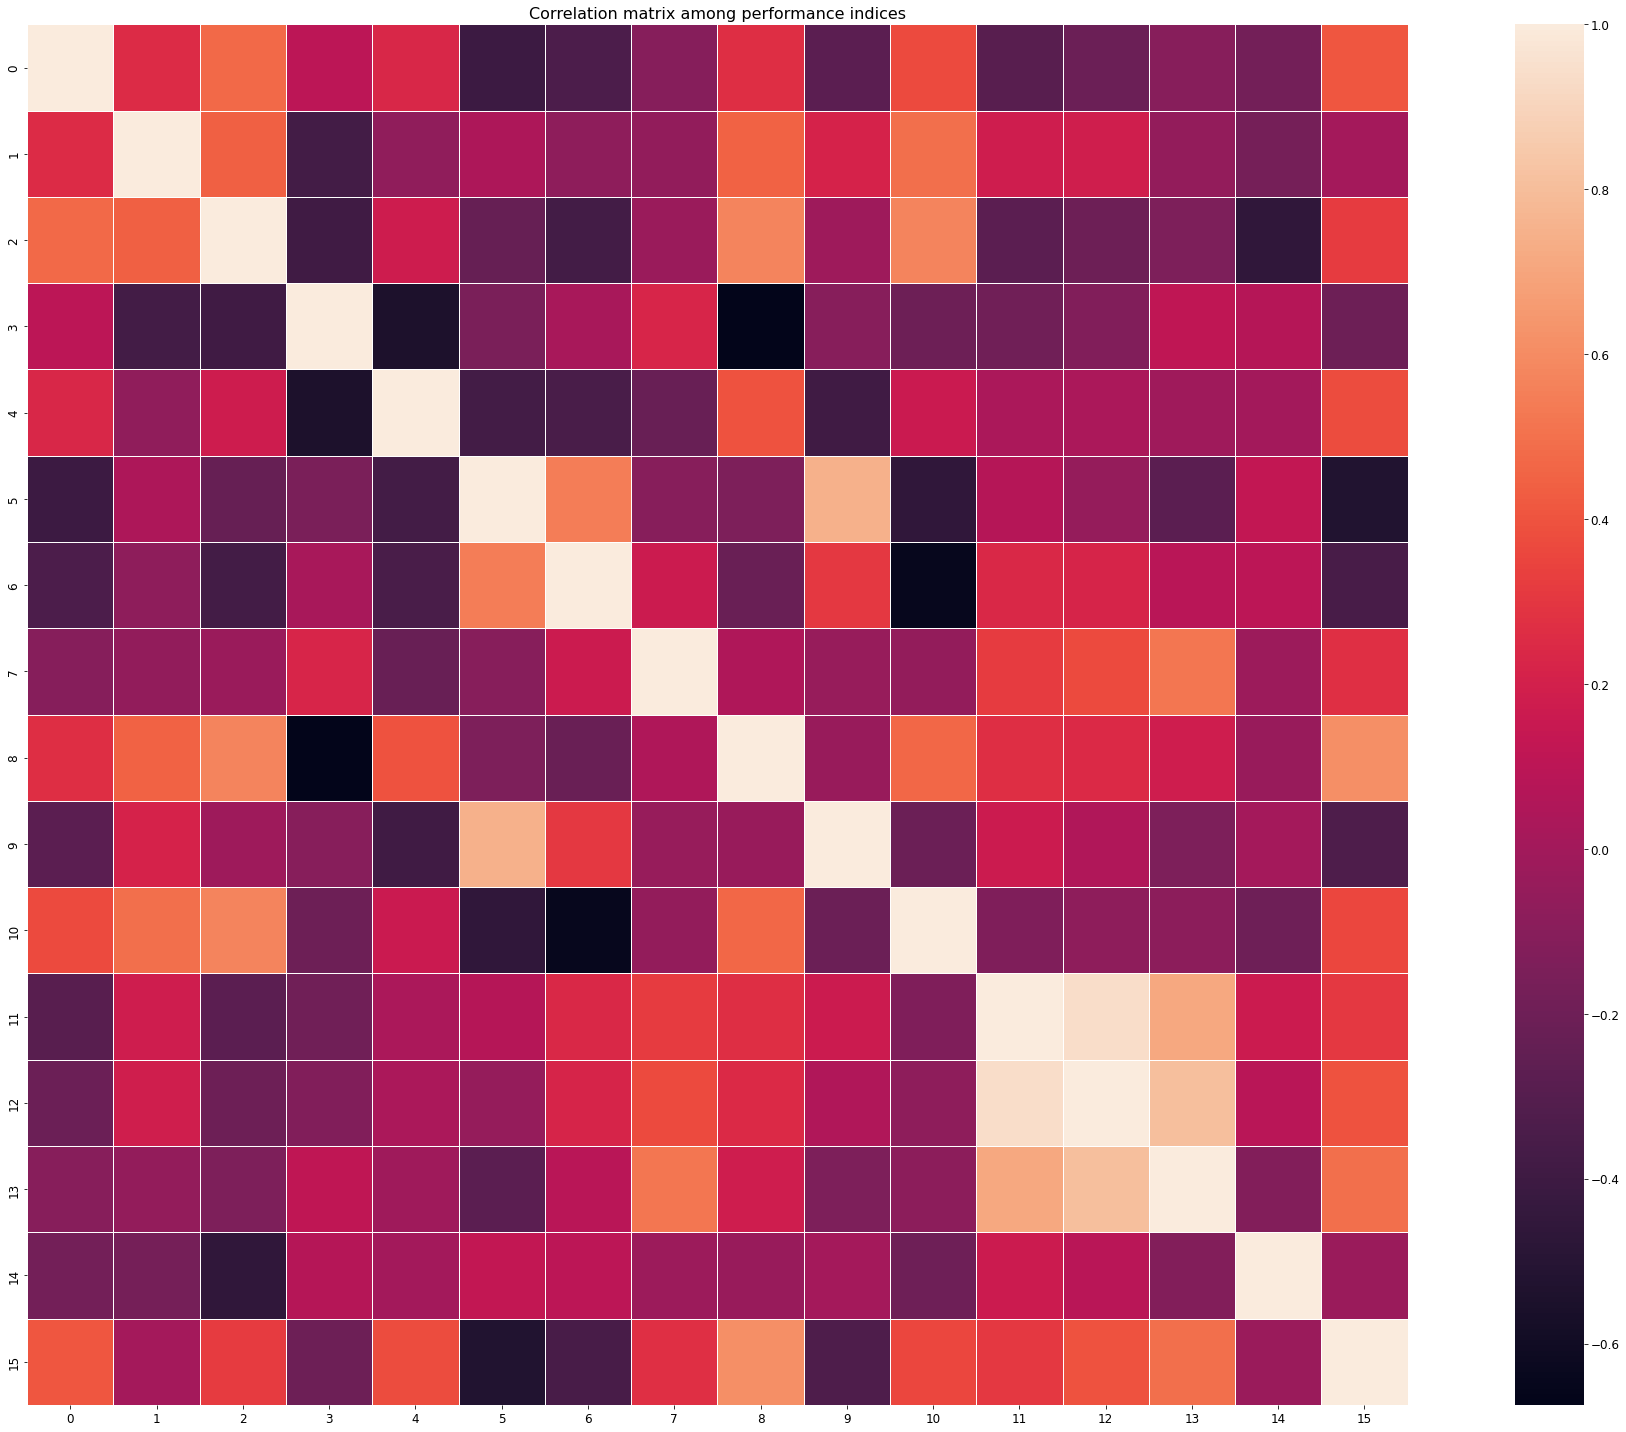

In [13]:
# Correlation among performance indices of players
corr_mat = df.corr(method="spearman")

plt.figure(figsize=(30, 20))
sns.heatmap(corr_mat, square=True, annot=False, linewidths=.5)
plt.title("Correlation matrix among performance indices", size=16)
plt.tight_layout()
save_fig("performance_correlation")

In [15]:
# Get the most correlated pairs of indices
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

tri_corr_mat = corr_mat.unstack()
cells_to_drop = get_redundant_pairs(df)
tri_corr_mat = tri_corr_mat.drop(labels=cells_to_drop).sort_values(ascending=False)

print("Top 10 positive correlated feature pairs:\n" + str(tri_corr_mat[0:10]))
print("\n----------------------------------------------------------------")
print("\nTop 10 negative correlated feature pairs:\n"+ str(tri_corr_mat[-10:]))
print("\n----------------------------------------------------------------")
print("\nTop 10 feature pairs:\n" + str(tri_corr_mat.abs().sort_values(ascending=False)[:10]))

Top 10 positive correlated feature pairs:
11  12    0.939399
12  13    0.805212
5   9     0.749503
11  13    0.711960
8   15    0.610432
2   8     0.574209
    10    0.572951
5   6     0.543003
7   13    0.522391
1   10    0.490823
dtype: float64

----------------------------------------------------------------

Top 10 negative correlated feature pairs:
1  3    -0.377309
4  9    -0.387408
2  3    -0.391041
0  5    -0.412439
5  10   -0.458728
2  14   -0.463374
5  15   -0.527710
3  4    -0.544997
6  10   -0.642917
3  8    -0.674337
dtype: float64

----------------------------------------------------------------

Top 10 feature pairs:
11  12    0.939399
12  13    0.805212
5   9     0.749503
11  13    0.711960
3   8     0.674337
6   10    0.642917
8   15    0.610432
2   8     0.574209
    10    0.572951
3   4     0.544997
dtype: float64


In [16]:
# Percentage of feature pairs having a strong correlation 
tri_corr_mat_pos = tri_corr_mat.abs().sort_values(ascending=False)
len(tri_corr_mat_pos[tri_corr_mat_pos > 0.40]) / len(tri_corr_mat_pos)

0.19166666666666668

## 4 - Preprocessing

### Train-test Split

In [24]:
# Split train-test
def train_test_split(df, test_size=0.2):
    shuffle_index = np.array(df.index)
    np.random.shuffle(shuffle_index)
    train_inds = shuffle_index[:-int(len(df)*test_size)]
    test_inds = shuffle_index[-int(len(df)*test_size):]
    return df.iloc[train_inds, :-1], df.iloc[train_inds, -1:], df.iloc[test_inds, :-1], df.iloc[test_inds, -1:]
X_train, y_train, X_test, y_test = train_test_split(df, test_size=0.2)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
13,35.0,28.0,71.0,8.8,3.29,11.1,86.3,3042.0,14.7,44.6,11.4,31.0,21.0,64.0,60.0
46,10.0,55.0,70.0,7.3,3.11,12.1,88.9,3033.0,5.9,51.0,14.0,144.0,66.0,20.0,61.0
22,42.0,40.0,77.0,6.1,3.45,10.4,71.8,2269.0,22.7,41.4,19.5,8.0,3.0,5.0,53.0
54,41.0,37.0,78.0,6.2,3.25,12.3,89.5,5308.0,25.9,59.7,10.3,65.0,28.0,102.0,52.0
15,35.0,46.0,85.0,7.1,3.22,11.8,79.9,1441.0,14.8,51.2,16.1,1.0,1.0,1.0,54.0


### Feature Scaling

In [25]:
# Normalize the data
def normalize_and_add_ones(X):
    X_max = np.max(X, axis = 0)
    X_min = np.min(X, axis = 0)
    X_range = X_max - X_min
    X_normalized = (X - X_min) / (X_range)
    ones = np.ones((X_normalized.shape[0]))
    return np.column_stack((ones, X_normalized))

X_train_normalized = normalize_and_add_ones(X_train)
X_train_normalized

array([[1.        , 0.5       , 0.29090909, 0.36363636, 0.47368421,
        0.64912281, 0.55555556, 0.81589958, 0.26590267, 0.36870027,
        0.29439252, 0.11242604, 0.04636785, 0.06289308, 0.22743682,
        0.62857143],
       [1.        , 0.        , 0.78181818, 0.31818182, 0.21052632,
        0.33333333, 0.92592593, 0.92468619, 0.26440791, 0.13527851,
        0.59345794, 0.26627219, 0.22102009, 0.20440252, 0.06859206,
        0.65714286],
       [1.        , 0.64      , 0.50909091, 0.63636364, 0.        ,
        0.92982456, 0.2962963 , 0.20920502, 0.13751868, 0.58090186,
        0.14485981, 0.59171598, 0.01081917, 0.00628931, 0.01444043,
        0.42857143],
       [1.        , 0.62      , 0.45454545, 0.68181818, 0.01754386,
        0.57894737, 1.        , 0.94979079, 0.64225212, 0.66578249,
        1.        , 0.04733728, 0.09891808, 0.08490566, 0.36462094,
        0.4       ],
       [1.        , 0.5       , 0.61818182, 1.        , 0.1754386 ,
        0.52631579, 0.81481481, 

## Ridge Regression

### Build the Model

In [105]:
# Ridge Regression
class RidgeRegression:
    def __init__(self) -> None:
        self.X = None
        self.W = None
        
    def _train_config(self, X_train, Y_train):
        assert len(X_train.shape) == 2 and X_train.shape[0] == Y_train.shape[0]
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        self.X = X_train
        return X_train, Y_train
    
    def fit(self, X_train, Y_train, LAMBDA):
        X_train, Y_train = self._train_config(X_train, Y_train)
        self.W = np.linalg.inv(X_train.T.dot(X_train) \
                 + LAMBDA * np.identity(X_train.shape[1])).dot(X_train.T).dot(Y_train)
        return self
    
    def predict(self, X):
        assert self.W is not None and self.X.shape[1] == X.shape[1]
        X = np.array(X)
        return X.dot(self.W)
    
    def compute_RSS(self, Y, Y_pred):
        assert Y.shape[0] == Y_pred.shape[0]
        Y = np.array(Y)
        Y_pred = np.array(Y_pred)
        m = Y.shape[0]
        
        loss = 1/m * (np.sum((Y - Y_pred)**2))
        return loss
    
    def get_the_best_LAMBDA(self, X_train, Y_train):
        def cross_validation(num_folds, LAMBDA):
            # get the index of all rows in the table
            row_ids = np.array(range(X_train.shape[0]))
            
            # valid end is the last index to get a valid split
            valid_end = len(row_ids) - len(row_ids) % num_folds
            valid_ids = np.split(row_ids[:valid_end], num_folds)
            
            # append the last index set which is not included in valid split above
            valid_ids.append(row_ids[valid_end:])
            
            # i-th training set may contain all number index k such that k not in i-th valid_ids
            train_ids = [[k for k in row_ids if k not in valid_ids[i]] for i in range (num_folds)]
            avg_RSS = 0
            for i in range (num_folds):
                valid_part = {"X": X_train[valid_ids[i]], "Y": Y_train[valid_ids[i]]}
                train_part = {"X": X_train[train_ids[i]], "Y": Y_train[train_ids[i]]}
                self.fit(train_part["X"], train_part["Y"], LAMBDA)
                Y_pred = self.predict(valid_part["X"])
                avg_RSS = avg_RSS + self.compute_RSS(valid_part["Y"], Y_pred)
            return avg_RSS / (num_folds)
            
        def range_scan(best_LAMBDA, minimum_RSS, LAMBDA_values):
            for LAMBDA in LAMBDA_values:
                RSS = cross_validation(5, LAMBDA)
                if RSS < minimum_RSS:
                    best_LAMBDA = LAMBDA
                    minimum_RSS = RSS
            return best_LAMBDA, minimum_RSS
        
        X_train, Y_train = self._train_config(X_train, Y_train)
        best_LAMBDA, minimum_RSS = range_scan(best_LAMBDA = 0, minimum_RSS = np.inf, 
                                              LAMBDA_values = np.array(range(50)))
        
        # after finding temp best_lambda, we continously scan from smaller range around best_lambda
        # (max(0, best_lambda - 1), best_lambda + 1) with step = 0.001
        LAMBDA_values = [
            k * 1./1000 for k in range(max(0, (best_LAMBDA - 1)*1000, (best_LAMBDA+1)*1000, 1))
        ]
        best_LAMBDA, minimum_RSS = range_scan(best_LAMBDA, minimum_RSS, LAMBDA_values)
        return best_LAMBDA

    def fit_gradient_descent(
        self, 
        X_train, Y_train, 
        LAMBDA, learning_rate, num_epochs = 100, batch_size = 4, epsilon = 1e-5
        ):
        X_train, Y_train = self._train_config(X_train, Y_train)
        
        # set-up some important value.
        # m = number of datapoints, n = number of features
        m = X_train.shape[0]
        n = X_train.shape[1]
        
        # initialize the first value of W
        self.W = np.random.randn(n)
        
        # shuffle the dataset
        inds = np.array(range(m))
        np.random.shuffle(inds)
        X_train = X_train[inds]
        Y_train = Y_train[inds]
        
        loss = np.inf
        loss_history = []
        for epoch in range (num_epochs):
            #print("training epoch {}".format(epoch + 1))
            num_batchs = m // batch_size
            #print("number of batch:", num_batchs)
            for i in range(num_batchs):
                #print("{}-th batch".format(i+1))
                index = i * batch_size
                X_batch = X_train[index:index+batch_size]
                Y_batch = Y_train[index:index+batch_size]
                grad = X_batch.T.dot(X_batch.dot(self.W) - Y_batch.squeeze()) + LAMBDA * self.W
                self.W = self.W - grad*learning_rate
            new_loss = self.compute_RSS(Y_train, self.predict(X_train))
            loss_history.append(new_loss)
            if abs(new_loss - loss) < epsilon:
                #print("stop_loss =", abs(new_loss - loss))
                break
            loss = new_loss
        #print("trained with {} epochs".format(epoch))
        return loss_history

### Test the Model

In [45]:
# Train the model
ridge_reg = RidgeRegression()
best_LAMBDA = ridge_reg.get_the_best_LAMBDA(X_train_normalized, y_train.values)
print("Best LAMBDA:", best_LAMBDA)
ridge_reg.fit(X_train_normalized, y_train, best_LAMBDA)
ridge_reg.compute_RSS(y_train, ridge_reg.predict(X_train_normalized))

Best LAMBDA: 0.013


784.0266777427711

In [46]:
# Test the model 
X_test_normalized = normalize_and_add_ones(X_test)
y_pred = ridge_reg.predict(X_test_normalized)
ridge_reg.compute_RSS(y_test, y_pred)

1930.9511778129854

In [108]:
# Train the model (gradient descent)
ridge_reg = RidgeRegression()
loss_history = ridge_reg.fit_gradient_descent(
    X_train_normalized, y_train,
    LAMBDA = best_LAMBDA,
    num_epochs=10000,
    learning_rate=0.03,
    batch_size=8
    )
ridge_reg.compute_RSS(y_train, ridge_reg.predict(X_train_normalized))

362064.43178443896

Saving figure loss_curve_gd


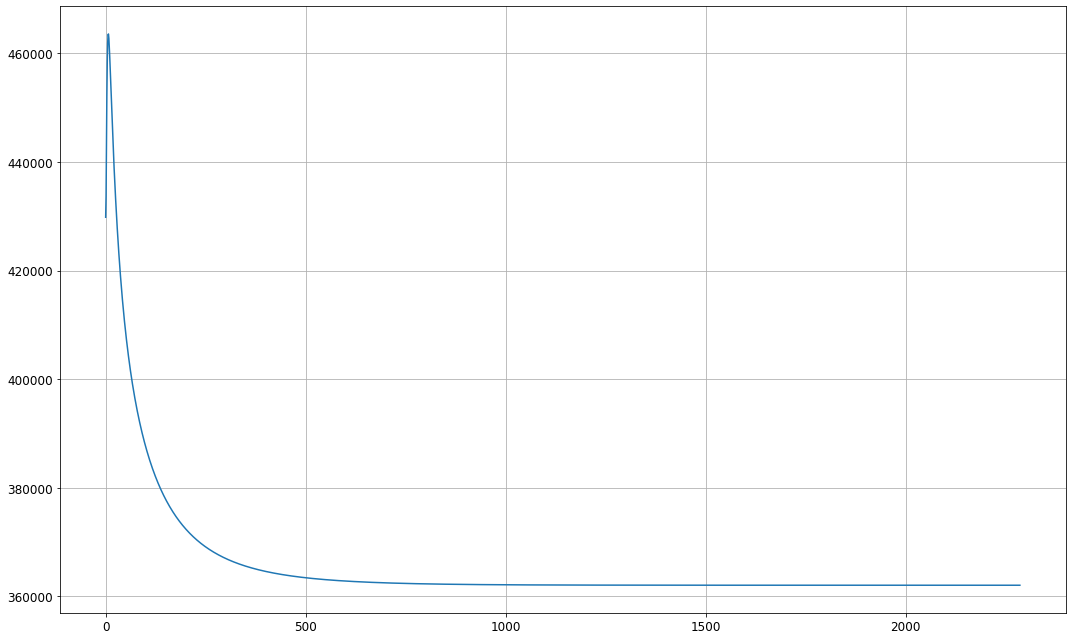

In [109]:
# Plot loss curve
plt.figure(figsize=(15, 9))
plt.plot(loss_history)
plt.grid()
save_fig("loss_curve_gd")